In [1]:
import yfinance as yf
import json
import threading
import pickle
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Ejemplo guiado de como ARIMA estima el día anterior y es inservible en nuestra aplicación.

In [2]:
ml = pickle.load(open('modelosEntrenados/Health/JNJ.pkl', 'rb'))
ml.summary()

In [3]:
warnings.filterwarnings('ignore')

In [4]:
companies = json.load(open('companies.json'))
health = [yf.Ticker(i).history(period='1d', start='2021-01-01', end='2021-12-31')[['Close','Volume']] for i in companies['Health']]


idx = 10
health[idx]['Volume'] = health[idx]['Volume']/health[idx]['Volume'].max()
health[idx]['Volume'] = health[idx]['Volume'].shift(1)
health[idx]['Volume'][idx] = 0
health[idx]['Close'] = health[idx]['Close']/health[idx]['Close'].max()


# Ejemplo concreto para la primera accion de Health, tendriamos que hacerlo para todas.
tr_start,tr_end = '2021-01-01','2021-06-01'
te_start,te_end = '2021-06-02','2021-12-31'
tra = health[10][['Close', 'Volume']][tr_start:tr_end].dropna()
tes = health[10][['Close', 'Volume']][te_start:te_end].dropna()
predictions = [0]*len(tes)
for i in range(len(tes)):
    ml = SARIMAX(list(tra['Close'])+list(tes['Close'][0:i]), exog = list(tra['Volume'])+list(tes['Volume'][0:i]), order=(1,0,0), seasonal_order=(0,0,0,0)).fit()
    predictions[i]= ml.get_forecast(steps = 1, exog = tes['Volume'][i]).predicted_mean[0]
print(ml.summary()) 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 654.401
Date:                Wed, 29 Nov 2023   AIC                          -1302.801
Time:                        09:35:33   BIC                          -1292.237
Sample:                             0   HQIC                         -1298.549
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0008      0.008     -0.102      0.919      -0.017       0.015
ar.L1          0.9997      0.001    746.994      0.000       0.997       1.002
sigma2         0.0003   1.39e-05     21.738      0.0

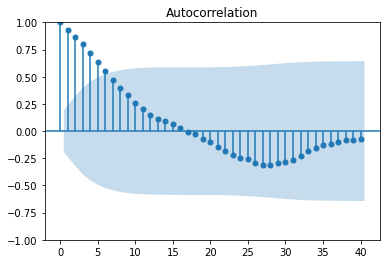

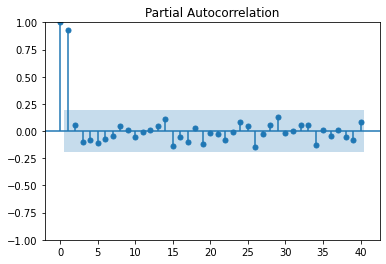

In [9]:
# See the ACF and PACF of the time series
plot_acf(tra['Close'], lags = 40)
plot_pacf(tra['Close'], lags = 40)
plt.show()


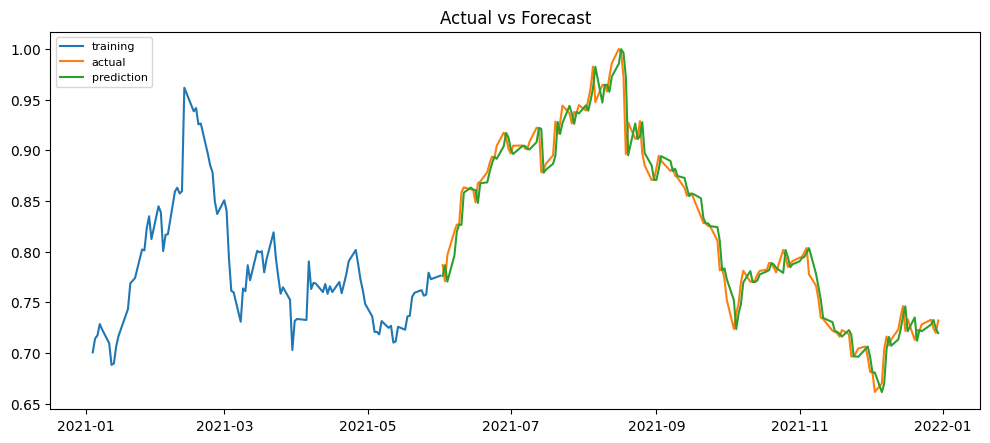

In [6]:
error = np.mean(np.abs(tes['Close'].values - predictions))
plt.figure(figsize=(12,5), dpi=100)
plt.plot(tra.index,tra['Close'].values, label='training')
plt.plot(tes.index,tes['Close'].values, label='actual')
plt.plot(tes.index,predictions, label='prediction')
plt.title('Actual vs Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# Es un puto random walk. Fooooock.
# Predicts the last day.

In [7]:
prueba = tes['Close'].values
# Lag prueba by 1 day
prueba = np.roll(prueba, 1)

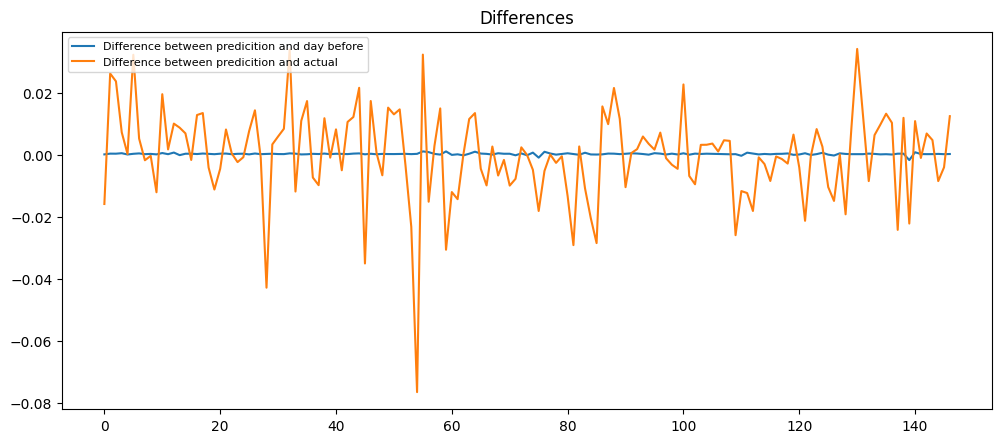

In [8]:
# Difference between prueba and predictions and tes['Close'].values and predictions except for first value
diff = prueba - predictions
diff = diff[1:]
diff1 = tes['Close'].values - predictions
diff1 = diff1[1:]
plt.figure(figsize=(12,5), dpi=100)
plt.plot(diff, label='Difference between predicition and day before')
plt.plot(diff1, label='Difference between predicition and actual')
plt.title('Differences')
plt.legend(loc='upper left', fontsize=8)
plt.show()